Evaluating the performance of K nearest-neighbors classifier combined with different dimension reduction methods on the CIFAR-10 dataset.

In [1]:
import numpy as np
import sys
from multiprocessing import cpu_count
from dimension_reduction_methods import (
    pca_wrapper, 
    wrapper_data_projection
)
from knn_classifier import wrapper_knn, knn_parameter_search
from sklearn.model_selection import StratifiedShuffleSplit
from collections import defaultdict
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter

%matplotlib inline

In [2]:
# Define some constants
methods_list = ['LPP', 'OLPP', 'NPP', 'ONPP', 'PCA']
n_jobs = max(cpu_count() - 2, 1)
seed_rng = np.random.randint(1, high=10000)
metric_primary = 'cosine'
shared_nearest_neighbors = False
# Choices are {'simple', 'SNN', 'heat_kernel'}
edge_weights = 'heat_kernel'

# Preprocessing with PCA as a first step of dimension reduction
pca_cutoff = 0.99

# Neighborhood size is chosen as a function of the number of data points. 
# In [1], it is recommended to chose `k = n^{2 / 5} = n^0.4`
neighborhood_constant = 0.4

COLORS = ['r', 'b', 'g', 'y', 'orange', 'm', 'lawngreen', 'gold', 'c', 'hotpink']

In [3]:
# Load a local copy of the CIFAR-10 data
data_path_local = '/Users/jayaram/Documents/research/data/cifar-10-batches-py'
if data_path_local not in sys.path:
    sys.path.append(data_path_local)
    
from load_cifar10_data import load_cifar_10_data
data, labels, _, data_test, labels_test, _, _ = load_cifar_10_data(data_path_local, vectorize=True)

In [4]:
# Combine the pre-defined train/test splits and create a new 50:50 stratified split
data_all = np.concatenate([data, data_test], axis=0)
labels_all = np.concatenate([labels, labels_test])

# Scale the feature values to the range [0, 1]
data_all = data_all / 255.

In [5]:
# Create a random, stratified train/test split
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=seed_rng)
data = labels = None
data_test = labels_test = None
for index_tr, index_te in sss.split(data_all, labels_all):
    data = data_all[index_tr, :]
    labels = labels_all[index_tr]
    data_test = data_all[index_te, :]
    labels_test = labels_all[index_te]

N, d = data.shape
N_te = labels_test.shape[0]
label_set, label_counts = np.unique(labels, return_counts=True)
_, label_counts_test = np.unique(labels_test, return_counts=True)

print("Number of features = {:d}. Number of classes = {:d}.".format(d, label_set.shape[0]))
print("\nNumber of training samples = {:d}.".format(N))
print("Number of samples per class in the training set:")
print(label_counts)

print("\nNumber of test samples = {:d}.".format(N_te))
print("Number of samples per class in the test set:")
print(label_counts_test)

Number of features = 3072. Number of classes = 10.

Number of training samples = 30000.
Number of samples per class in the training set:
[3000 3000 3000 3000 3000 3000 3000 3000 3000 3000]

Number of test samples = 30000.
Number of samples per class in the test set:
[3000 3000 3000 3000 3000 3000 3000 3000 3000 3000]


INFO:dimension_reduction_methods:Applying PCA as first-level dimension reduction step
INFO:dimension_reduction_methods:Number of nonzero singular values in the data matrix = 3072
INFO:dimension_reduction_methods:Number of principal components accounting for 99.0 percent of the data variance = 652
INFO:dimension_reduction_methods:Dimension of the PCA transformed data = 652
INFO:dimension_reduction_methods:Dimension of the projected subspace = 3
INFO:dimension_reduction_methods:Solving the generalized eigenvalue problem to find the optimal projection matrix.


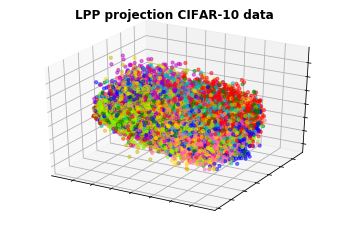

INFO:dimension_reduction_methods:Applying PCA as first-level dimension reduction step
INFO:dimension_reduction_methods:Number of nonzero singular values in the data matrix = 3072
INFO:dimension_reduction_methods:Number of principal components accounting for 99.0 percent of the data variance = 652
INFO:dimension_reduction_methods:Dimension of the PCA transformed data = 652
INFO:dimension_reduction_methods:Dimension of the projected subspace = 3
INFO:dimension_reduction_methods:Solving the generalized eigenvalue problem to find the optimal projection matrix.


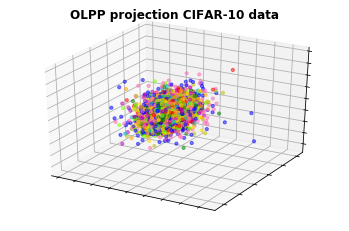

INFO:dimension_reduction_methods:Applying PCA as first-level dimension reduction step
INFO:dimension_reduction_methods:Number of nonzero singular values in the data matrix = 3072
INFO:dimension_reduction_methods:Number of principal components accounting for 99.0 percent of the data variance = 652
INFO:dimension_reduction_methods:Dimension of the PCA transformed data = 652
INFO:dimension_reduction_methods:Dimension of the projected subspace = 3
INFO:dimension_reduction_methods:Solving the generalized eigenvalue problem to find the optimal projection matrix.


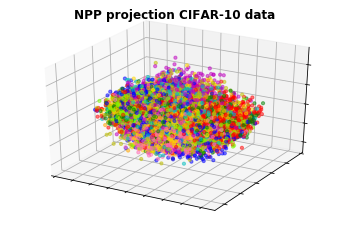

INFO:dimension_reduction_methods:Applying PCA as first-level dimension reduction step
INFO:dimension_reduction_methods:Number of nonzero singular values in the data matrix = 3072
INFO:dimension_reduction_methods:Number of principal components accounting for 99.0 percent of the data variance = 652
INFO:dimension_reduction_methods:Dimension of the PCA transformed data = 652
INFO:dimension_reduction_methods:Dimension of the projected subspace = 3
INFO:dimension_reduction_methods:Solving the generalized eigenvalue problem to find the optimal projection matrix.


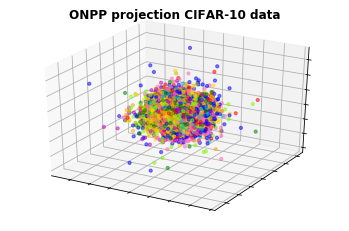

INFO:dimension_reduction_methods:Number of nonzero singular values in the data matrix = 3072
INFO:dimension_reduction_methods:Number of principal components accounting for 99.0 percent of the data variance = 652
INFO:dimension_reduction_methods:Dimension of the PCA transformed data = 3


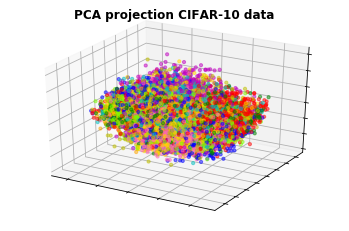

In [6]:
# Scatter plot of the 3D projection
label_map = {v: i for i, v in enumerate(label_set)}
c = [COLORS[label_map[v]] for v in labels]
for method in methods_list:
    data_proj = wrapper_data_projection(data, method, metric='cosine', snn=False, ann=True, dim_proj=3, 
                                        pca_cutoff=pca_cutoff, n_jobs=n_jobs, seed_rng=seed_rng)
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(data_proj[:, 0], data_proj[:, 1], data_proj[:, 2], marker='o', c=c, s=10, alpha=0.5)
    ax.set_title('{} projection CIFAR-10 data'.format(method), fontweight='bold')
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.zaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')
    plt.show()

### Baseline performance of a KNN classifier

In [7]:
metric = 'cosine'
snn = False
n_neighbors = 10
dim_proj_range = np.linspace(10, 200, num=10, dtype=np.int)

error_rate_test = defaultdict(lambda: np.zeros(dim_proj_range.shape[0]))

In [8]:
# KNN classifier with PCA applied as pre-processing
data_proj, mean_data, transform_pca = pca_wrapper(data, cutoff=pca_cutoff, seed_rng=seed_rng)
data_test_proj = np.dot(data_test - mean_data, transform_pca)
error_rate_baseline = wrapper_knn(data_proj, labels, n_neighbors,
                                  data_test=data_test_proj, labels_test=labels_test,
                                  metric=metric, 
                                  shared_nearest_neighbors=snn,
                                  n_jobs=n_jobs,
                                  seed_rng=seed_rng)
print("Baseline error rate on the test data = {:.6f}".format(error_rate_baseline))

INFO:dimension_reduction_methods:Number of nonzero singular values in the data matrix = 3072
INFO:dimension_reduction_methods:Number of principal components accounting for 99.0 percent of the data variance = 652
INFO:dimension_reduction_methods:Dimension of the PCA transformed data = 652


Baseline error rate on the test data = 0.594067


### Searching for the best `k`
Instead of using a heuristic choice of `k`, the number of neighbors, we search over a range of `k` values and select the `k` value that leads to minimum cross-validated error rate. The performance of the classifier is then evaluated on the test data for the selected value of `k`.

In [9]:
# Search range for k
k_range = np.linspace(5, 30, num=10, dtype=np.int)
num_cv_folds = 5

In [10]:
k_best, _, error_rate_cv, _ = knn_parameter_search(
    data, labels, k_range,
    num_cv_folds=num_cv_folds,
    metric=metric,
    shared_nearest_neighbors=snn,
    skip_preprocessing=False,
    pca_cutoff=pca_cutoff,
    n_jobs=n_jobs,
    seed_rng=seed_rng
)

INFO:dimension_reduction_methods:Number of nonzero singular values in the data matrix = 3072
INFO:dimension_reduction_methods:Number of principal components accounting for 99.0 percent of the data variance = 652
INFO:dimension_reduction_methods:Dimension of the PCA transformed data = 652
INFO:knn_classifier:Performing cross-validation to search for the best number of neighbors:
INFO:knn_classifier:Best value of k (number of neighbors) = 18. Data dimension = 652. Cross-validation error rate = 0.597733


In [11]:
# KNN classifier with the selected k
err_rate = wrapper_knn(data_proj, labels, k_best,
                       data_test=data_test_proj, labels_test=labels_test,
                       metric=metric, 
                       shared_nearest_neighbors=snn,
                       n_jobs=n_jobs,
                       seed_rng=seed_rng)
print("Error rate on the test data with k selected using cross-validation = {:.6f}".format(err_rate))

Error rate on the test data with k selected using cross-validation = 0.593467


### Performance of a KNN classifier as a function of the projection dimension
Next, we evaluate the performance of a KNN classifier with different dimensionality reductions methods applied as pre-processing, and the reduced dimension varied over a range of values.  

In [12]:
for method in methods_list:
    print("KNN classifier with dimension reduction using {}".format(method))
    # First project the data to different reduced dimensions using the current method
    data_proj_list, data_test_proj_list = wrapper_data_projection(data, method, data_test=data_test,
                                                                  dim_proj=dim_proj_range,
                                                                  metric=metric, 
                                                                  snn=snn, 
                                                                  ann=True, 
                                                                  pca_cutoff=pca_cutoff, 
                                                                  n_jobs=n_jobs, 
                                                                  seed_rng=seed_rng)
    for j in range(dim_proj_range.shape[0]):
        # KNN classifier on the projected data
        error_rate_test[method][j] = wrapper_knn(data_proj_list[j], labels, n_neighbors,
                                                 data_test=data_test_proj_list[j], labels_test=labels_test,
                                                 metric=metric, 
                                                 shared_nearest_neighbors=snn,
                                                 n_jobs=n_jobs,
                                                 seed_rng=seed_rng)

INFO:dimension_reduction_methods:Applying PCA as first-level dimension reduction step


KNN classifier with dimension reduction using LPP


INFO:dimension_reduction_methods:Number of nonzero singular values in the data matrix = 3072
INFO:dimension_reduction_methods:Number of principal components accounting for 99.0 percent of the data variance = 652
INFO:dimension_reduction_methods:Dimension of the PCA transformed data = 652
INFO:dimension_reduction_methods:Dimension of the projected subspace = 200
INFO:dimension_reduction_methods:Solving the generalized eigenvalue problem to find the optimal projection matrix.
INFO:dimension_reduction_methods:Applying PCA as first-level dimension reduction step


KNN classifier with dimension reduction using OLPP


INFO:dimension_reduction_methods:Number of nonzero singular values in the data matrix = 3072
INFO:dimension_reduction_methods:Number of principal components accounting for 99.0 percent of the data variance = 652
INFO:dimension_reduction_methods:Dimension of the PCA transformed data = 652
INFO:dimension_reduction_methods:Dimension of the projected subspace = 200
INFO:dimension_reduction_methods:Solving the generalized eigenvalue problem to find the optimal projection matrix.
INFO:dimension_reduction_methods:Applying PCA as first-level dimension reduction step


KNN classifier with dimension reduction using NPP


INFO:dimension_reduction_methods:Number of nonzero singular values in the data matrix = 3072
INFO:dimension_reduction_methods:Number of principal components accounting for 99.0 percent of the data variance = 652
INFO:dimension_reduction_methods:Dimension of the PCA transformed data = 652
INFO:dimension_reduction_methods:Dimension of the projected subspace = 200
INFO:dimension_reduction_methods:Solving the generalized eigenvalue problem to find the optimal projection matrix.
INFO:dimension_reduction_methods:Applying PCA as first-level dimension reduction step


KNN classifier with dimension reduction using ONPP


INFO:dimension_reduction_methods:Number of nonzero singular values in the data matrix = 3072
INFO:dimension_reduction_methods:Number of principal components accounting for 99.0 percent of the data variance = 652
INFO:dimension_reduction_methods:Dimension of the PCA transformed data = 652
INFO:dimension_reduction_methods:Dimension of the projected subspace = 200
INFO:dimension_reduction_methods:Solving the generalized eigenvalue problem to find the optimal projection matrix.


KNN classifier with dimension reduction using PCA


INFO:dimension_reduction_methods:Number of nonzero singular values in the data matrix = 3072
INFO:dimension_reduction_methods:Number of principal components accounting for 99.0 percent of the data variance = 652
INFO:dimension_reduction_methods:Dimension of the PCA transformed data = 200


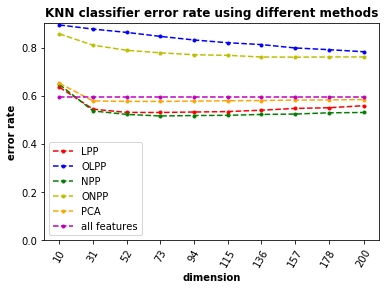

In [13]:
# Error rate of different methods as a function of projected dimension
fig = plt.figure()
y_min = error_rate_baseline
y_max = error_rate_baseline
j = 0
for method in methods_list: 
    plt.plot(dim_proj_range, error_rate_test[method], linestyle='--', color=COLORS[j], 
             marker='.', label=method)
    j += 1
    a = min(error_rate_test[method])
    b = max(error_rate_test[method])
    if a < y_min:
        y_min = a
        
    if b > y_max:
        y_max = b

# Baseline using all features
plt.plot(dim_proj_range, error_rate_baseline * np.ones(dim_proj_range.shape[0]), linestyle='--', 
         color=COLORS[j], marker='.', label='all features')
y_min = 0.
y_max = 1.01 * y_max
plt.xlabel('dimension', fontweight='bold')
plt.ylabel('error rate', fontweight='bold')
plt.ylim([y_min, y_max])
# plt.xscale('log')
plt.xticks(dim_proj_range, rotation=60)
plt.title('KNN classifier error rate using different methods', fontweight='bold')
plt.legend(loc='best')
plt.show()

### Searching for the best `k` and projected dimension
Next, we choose a particular dimension reduction method `NPP` and perform a joint search for the best `k` (number of neighbors) and projected dimension using 5-fold cross-validation. Then, we project the test data to the best dimension found and evaluate the performance of a KNN classifier for the best `k` found.

In [14]:
method_proj = 'NPP'
# Search range for the projected dimension
dim_proj_range = np.linspace(30, 100, num=10, dtype=np.int)

In [15]:
# Using NPP for dimension reduction
k_best, dim_best, error_rate_cv, _ = knn_parameter_search(
    data, labels, k_range, 
    dim_proj_range=dim_proj_range, 
    method_proj=method_proj,
    num_cv_folds=num_cv_folds,
    metric=metric,
    shared_nearest_neighbors=snn,
    pca_cutoff=pca_cutoff,
    n_jobs=n_jobs,
    seed_rng=seed_rng
)

INFO:knn_classifier:Using NPP for dimension reduction.
INFO:dimension_reduction_methods:Applying PCA as first-level dimension reduction step
INFO:dimension_reduction_methods:Number of nonzero singular values in the data matrix = 3072
INFO:dimension_reduction_methods:Number of principal components accounting for 99.0 percent of the data variance = 652
INFO:dimension_reduction_methods:Dimension of the PCA transformed data = 652
INFO:dimension_reduction_methods:Dimension of the projected subspace = 100
INFO:dimension_reduction_methods:Solving the generalized eigenvalue problem to find the optimal projection matrix.
INFO:knn_classifier:Performing cross-validation to search for the best combination of number of neighbors and projected data dimension:
INFO:knn_classifier:Best value of k (number of neighbors) = 30. Data dimension = 100. Cross-validation error rate = 0.495933


In [16]:
# Project the test data to the selected best dimension
data_proj, data_test_proj = wrapper_data_projection(data, method_proj, data_test=data_test,
                                                    dim_proj=dim_best,
                                                    metric=metric, 
                                                    snn=snn, 
                                                    pca_cutoff=pca_cutoff, 
                                                    n_jobs=n_jobs, 
                                                    seed_rng=seed_rng)
# KNN classifier performance of test data for chosen `k_best`
err_rate = wrapper_knn(data_proj, labels, k_best,
                       data_test=data_test_proj, labels_test=labels_test,
                       metric=metric, 
                       shared_nearest_neighbors=snn,
                       n_jobs=n_jobs,
                       seed_rng=seed_rng)
print("Error rate on test data with the selected best configuration = {:.6f}.".format(err_rate))

INFO:dimension_reduction_methods:Applying PCA as first-level dimension reduction step
INFO:dimension_reduction_methods:Number of nonzero singular values in the data matrix = 3072
INFO:dimension_reduction_methods:Number of principal components accounting for 99.0 percent of the data variance = 652
INFO:dimension_reduction_methods:Dimension of the PCA transformed data = 652
INFO:dimension_reduction_methods:Dimension of the projected subspace = 100
INFO:dimension_reduction_methods:Solving the generalized eigenvalue problem to find the optimal projection matrix.


Error rate on test data with the selected best configuration = 0.483867.
